## This file serves as an sandbox for exploring the Massachusetts_Public_Schools_2017 dataset. 

In [20]:
#Import pandas, numpy and matplotlib for data exploration
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [21]:
#Import public schools dataset and the data dictionary
raw_schools_data = pd.read_csv('data/MA_Public_Schools_2017.csv', low_memory = False)
data_dict = pd.read_csv('data/MA_Public_Schools_datadict.csv')

In [22]:
#Extract the relevant features from the full dataset
data_cut_down = raw_schools_data[['School Name', 'School Type', 'Town', 'Grade', 'District Name', 'PK_Enrollment', 'K_Enrollment', '1_Enrollment', '2_Enrollment', '3_Enrollment', '4_Enrollment', '5_Enrollment', '6_Enrollment', '7_Enrollment', '8_Enrollment', '9_Enrollment', '10_Enrollment', '11_Enrollment', '12_Enrollment', 'SP_Enrollment',
'TOTAL_Enrollment', '% First Language Not English', '% English Language Learner', '% Students With Disabilities', '% High Needs', '% Economically Disadvantaged', 'Average Class Size', 'Average Salary', 'FTE Count', 'In-District Expenditures', 'Average In-District Expenditures per Pupil', 'Total Pupil FTEs',
'Average Expenditures per Pupil', '# in Cohort', '% Graduated', '% Still in School', '% Non-Grad Completers', '% GED', '% Dropped Out', '% Permanently Excluded', 'High School Graduates (#)', 'Attending Coll./Univ. (#)', '% Attending College', 'SAT_Tests Taken', 'Average SAT_Reading', 'Average SAT_Writing', 
'Average SAT_Math', 'MCAS_10thGrade_Math_P+A #', '% MCAS_10thGrade_Math_P+A', 'MCAS_10thGrade_Math_A #', '% MCAS_10thGrade_Math_A', 'MCAS_10thGrade_Math_P #', '% MCAS_10thGrade_Math_P', 'MCAS_10thGrade_Math_NI #', '% MCAS_10thGrade_Math_NI', 'MCAS_10thGrade_Math_W/F #', '% MCAS_10thGrade_Math_W/F', 
'MCAS_10thGrade_Math_Stud. Incl. #', 'MCAS_10thGrade_Math_CPI', 'MCAS_10thGrade_Math_SGP', 'MCAS_10thGrade_English_P+A #', '% MCAS_10thGrade_English_P+A', 'MCAS_10thGrade_English_A #', '% MCAS_10thGrade_English_A', 'MCAS_10thGrade_English_P #', '% MCAS_10thGrade_English_P', 'MCAS_10thGrade_English_NI #',
'% MCAS_10thGrade_English_NI', 'MCAS_10thGrade_English_W/F #', '% MCAS_10thGrade_English_W/F', 'MCAS_10thGrade_English_Stud. Incl. #', 'MCAS_10thGrade_English_CPI', 'Accountability and Assistance Level', 'Accountability and Assistance Description', 'School Accountability Percentile (1-99)', 
'Progress and Performance Index (PPI) - All Students', 'Progress and Performance Index (PPI) - High Needs Students']]
print(data_cut_down.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861 entries, 0 to 1860
Data columns (total 77 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   School Name                                                 1861 non-null   object 
 1   School Type                                                 1861 non-null   object 
 2   Town                                                        1861 non-null   object 
 3   Grade                                                       1860 non-null   object 
 4   District Name                                               1861 non-null   object 
 5   PK_Enrollment                                               1861 non-null   int64  
 6   K_Enrollment                                                1861 non-null   int64  
 7   1_Enrollment                                                1861 non-null   int64  
 8 

In [23]:
#Parse out any schools that don't teach the 10th grade
data_cut_down['teaches_10th_grade'] = data_cut_down['Grade'].apply(lambda x: '10' in str(x))
schools_teaching_10th = data_cut_down[data_cut_down['teaches_10th_grade']].copy()
print(schools_teaching_10th.info())

<class 'pandas.core.frame.DataFrame'>
Index: 402 entries, 0 to 1858
Data columns (total 78 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   School Name                                                 402 non-null    object 
 1   School Type                                                 402 non-null    object 
 2   Town                                                        402 non-null    object 
 3   Grade                                                       402 non-null    object 
 4   District Name                                               402 non-null    object 
 5   PK_Enrollment                                               402 non-null    int64  
 6   K_Enrollment                                                402 non-null    int64  
 7   1_Enrollment                                                402 non-null    int64  
 8   2_En

C:\Users\jkaic\AppData\Local\Temp\ipykernel_30960\500439619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cut_down['teaches_10th_grade'] = data_cut_down['Grade'].apply(lambda x: '10' in str(x))


From here I can identify the fields to use as features when building the model. Since we are trying to predict the percentage of 10th grade students that will fail the MCAS at a given school, we want to focus on features that contain information about the school's demographic, location, funding, and employment.

Additionally, the fields needed to produce a target column must be defined. Because the percentage of failed students is broken out for each school and by subject, these factors need to be combined into a single metric that meaasures the failure rate of each school.

In [24]:
#create a list of features used to predict failure rate for the MCAS
features = ['Town', 'District Name', 'School Type', 'TOTAL_Enrollment', '% First Language Not English', '% English Language Learner', '% Students With Disabilities', '% High Needs', '% Economically Disadvantaged', 'Average Class Size', 'Average Salary', 'FTE Count', 'In-District Expenditures',
            'Average In-District Expenditures per Pupil', '% Graduated', '% Attending College', 'Average SAT_Reading', 'Average SAT_Writing', 'Average SAT_Math', 'Accountability and Assistance Level', 'School Accountability Percentile (1-99)',
            'Progress and Performance Index (PPI) - All Students', 'Progress and Performance Index (PPI) - High Needs Students', 'Total Pupil FTEs']
target_fields = ['% MCAS_10thGrade_Math_W/F', '% MCAS_10thGrade_English_W/F', 'MCAS_10thGrade_English_CPI']

In [25]:
#pull out a dataframe for the features and a dataframe for the tartet fields
feature_frame = schools_teaching_10th[features]
target_frame = schools_teaching_10th[target_fields]

## Step 2: The Target Variable

The primary goal of this model is to identify the most significant school characteristics that drive performance on the MCAS exams. As such, a single metric for evaluating a school's performance on the MCAS needs to be developed. For this purpose, I elected to use the average CPI for 10th grade students across all subjects. The CPI assigns the set of scores [0, 25, 50, 75, 100] based on how the student performs on the MCAS and then averages these values across the whole school. The reason I decided to focus only on 10th Grade CPIs is because this is the last chance for a student to pass the MCAS before it would prevent them from graduating, and therefore this should be the exam that most students are motivated to pass.

In [26]:
#List of CPI score fields for 10th grade students
schools_teaching_10th['Agg CPI'] = (schools_teaching_10th['MCAS_10thGrade_Math_CPI'] + schools_teaching_10th['MCAS_10thGrade_English_CPI']) / 2
print(schools_teaching_10th['Agg CPI'].describe())

count    351.000000
mean      93.174074
std        6.959799
min       45.000000
25%       91.450000
50%       95.100000
75%       97.650000
max      100.000000
Name: Agg CPI, dtype: float64


In [27]:
#Now that the target column has been created, I'll drop any rows missing the target variable and create a feature and target frame to separate out the values
target_populated = schools_teaching_10th.dropna(subset = ['Agg CPI'])

feature_frame = target_populated[features]
target_frame = target_populated[target_fields]


# Step 3: Feature Data

Next I sorted through the most important columns to check the data quality and dtermine how to deal with null values on a case by case basis. Please note that this exporation and feature engineering exercise was done with the subset of row items that had values for the target value to identify and address gaps for schools that would be used to train the model. However, the imputation methods shown here will be applied to the entire dataset to allow for more information to be used when imputing missing values. 

In [28]:
#print a high level summary of the feature dataframe
print(feature_frame.info())

<class 'pandas.core.frame.DataFrame'>
Index: 351 entries, 0 to 1858
Data columns (total 24 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Town                                                        351 non-null    object 
 1   District Name                                               351 non-null    object 
 2   School Type                                                 351 non-null    object 
 3   TOTAL_Enrollment                                            351 non-null    int64  
 4   % First Language Not English                                351 non-null    float64
 5   % English Language Learner                                  351 non-null    float64
 6   % Students With Disabilities                                351 non-null    float64
 7   % High Needs                                                351 non-null    float64
 8   % Ec

In [29]:
#Check to ensure there aren't any duplicate school names
print(schools_teaching_10th['School Name'].value_counts().head())

School Name
Abington High                      1
Norton High                        1
Pembroke High School               1
Peabody Veterans Memorial High     1
Pathfinder Vocational Technical    1
Name: count, dtype: int64


In [30]:
#For loop to describe each of the features selected
for f in feature_frame.columns:
    print(f)
    print(feature_frame[f].describe())
    print()

Town
count             351
unique            244
top       Springfield
freq               10
Name: Town, dtype: object

District Name
count        351
unique       294
top       Boston
freq          27
Name: District Name, dtype: object

School Type
count               351
unique                2
top       Public School
freq                311
Name: School Type, dtype: object

TOTAL_Enrollment
count     351.000000
mean      887.931624
std       544.503145
min        93.000000
25%       480.000000
50%       748.000000
75%      1208.500000
max      4264.000000
Name: TOTAL_Enrollment, dtype: float64

% First Language Not English
count    351.000000
mean      16.954986
std       20.624492
min        0.000000
25%        2.450000
50%        7.000000
75%       24.500000
max      100.000000
Name: % First Language Not English, dtype: float64

% English Language Learner
count    351.000000
mean       6.336752
std       10.768063
min        0.000000
25%        0.500000
50%        1.500000
75%    

In [31]:
#Note non-relevant fields and remove them from the feature dataset
non_relevant_fields = ['Town', 'FTE Count', 'TOTAL_Enrollment', 'In-District Expenditures', '% Graduated', '% Attending College', 'Accountability and Assistance Level', 'School Accountability Percentile (1-99)']
feature_frame_cut1 = feature_frame.drop(non_relevant_fields, axis = 1).copy()

In [32]:
#For loop to describe each of the features selected
for f in feature_frame_cut1.columns:
    print(f)
    print(feature_frame[f].describe())
    print()

District Name
count        351
unique       294
top       Boston
freq          27
Name: District Name, dtype: object

School Type
count               351
unique                2
top       Public School
freq                311
Name: School Type, dtype: object

% First Language Not English
count    351.000000
mean      16.954986
std       20.624492
min        0.000000
25%        2.450000
50%        7.000000
75%       24.500000
max      100.000000
Name: % First Language Not English, dtype: float64

% English Language Learner
count    351.000000
mean       6.336752
std       10.768063
min        0.000000
25%        0.500000
50%        1.500000
75%        7.150000
max       79.600000
Name: % English Language Learner, dtype: float64

% Students With Disabilities
count    351.000000
mean      17.333903
std       10.065325
min        0.000000
25%       12.350000
50%       15.500000
75%       19.300000
max      100.000000
Name: % Students With Disabilities, dtype: float64

% High Needs
count   

There are 5 fields that describe demographic information about the student population where exactly 6 data points are missing. These row items are extracted to determine if it's the same institutions that are missing this data, and if so, there are any commonalities that's causing this info to be missing.

In [33]:
#For loop to extract the names of the schools with missing data in the 5 demographic feature columns 
missing_demo_info = ['% First Language Not English',  '% English Language Learner', '% Students With Disabilities', '% High Needs', '% Economically Disadvantaged']

#for loop to create a column in the original dataframe noting where schools are missing demographic info
missing_demo_data = schools_teaching_10th.copy()
schools_missing_demo = {}

for f in missing_demo_info:
    school_list = []
    missing_demo_data['missing_{}'.format(f)] = missing_demo_data[f].isnull()
    school_list = missing_demo_data[missing_demo_data['missing_{}'.format(f)]]['School Name'].to_list()
    schools_missing_demo['missing_{}'.format(f)] = school_list

missing_data_list = []

for s in schools_missing_demo:
    
    for i in schools_missing_demo[s]:
        if i not in missing_data_list:
            missing_data_list.append(i)

print(len(missing_data_list))

6


Since the same 6 schools are missing demographic information, I decided to remove these schools from the dataset using the dropna function.

In [34]:
#drop schools missing demographic information
feature_frame_cut1.dropna(axis = 0, subset = ['% First Language Not English'], inplace = True)
print(feature_frame_cut1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 351 entries, 0 to 1858
Data columns (total 16 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   District Name                                               351 non-null    object 
 1   School Type                                                 351 non-null    object 
 2   % First Language Not English                                351 non-null    float64
 3   % English Language Learner                                  351 non-null    float64
 4   % Students With Disabilities                                351 non-null    float64
 5   % High Needs                                                351 non-null    float64
 6   % Economically Disadvantaged                                351 non-null    float64
 7   Average Class Size                                          348 non-null    float64
 8   Aver

Next, we need to address the missing values for average class size, average salary, and average in-district expenditures per pupil. To impute these values, I'd like to use information about other schools within the district to impute these values, but I need to make sure that there is sufficient data for this approach first.

In [35]:
#check the mean and median values for average class size, average salary, and average in district expenditures per pupil by district
avg_class_info = feature_frame_cut1[['District Name', 'Average Class Size', 'Average Salary', 'Average In-District Expenditures per Pupil']].groupby('District Name').agg('mean')
med_class_info = feature_frame_cut1[['District Name', 'Average Class Size', 'Average Salary', 'Average In-District Expenditures per Pupil']].groupby('District Name').agg('median')

print('Average Class Size Missing Means')
print(avg_class_info['Average Class Size'].isna().sum())
print()
print('Average Salary Missing Medians')
print(avg_class_info['Average Salary'].isna().sum())
print()
print('Average In-District Expenditures per Pupil Missing Means')
print(avg_class_info['Average In-District Expenditures per Pupil'].isna().sum())
print()
print('Average Class Size Missing Medians')
print(med_class_info['Average Class Size'].isna().sum())
print()
print('Average Salary Missing Medians')
print(med_class_info['Average Salary'].isna().sum())
print()
print('Average In-District Expenditures per Pupil Missing Medians')
print(med_class_info['Average In-District Expenditures per Pupil'].isna().sum())

Average Class Size Missing Means
1

Average Salary Missing Medians
42

Average In-District Expenditures per Pupil Missing Means
42

Average Class Size Missing Medians
1

Average Salary Missing Medians
42

Average In-District Expenditures per Pupil Missing Medians
42


In [36]:
#Make a list of districts missing class size info and compare it to list of districts missing aggregate class size info
districts_missing_class_size = np.unique(feature_frame_cut1[feature_frame_cut1['Average Class Size'].isna()]['District Name'].to_numpy())
districts_missing_agg_class_size = np.unique(avg_class_info[avg_class_info['Average Class Size'].isna()].index.to_numpy())

#print the districts that won't be able to be filled with aggregate data
districts_filled_with_agg_class_size = []
for dis in districts_missing_class_size:
    if dis not in districts_missing_agg_class_size:
        districts_filled_with_agg_class_size.append(dis)

print('The following is a list of districts where one or more schools are missing average class size data, but aggregate district data is available. Aggregate district data will be used to impute these values.')
print(districts_filled_with_agg_class_size)
print()
print('The following is a list of districts where one or more schools are missing average class size data, and aggregate district data is  NOT available. Aggregate State data will be used to impute these values.')
print(districts_missing_agg_class_size)

The following is a list of districts where one or more schools are missing average class size data, but aggregate district data is available. Aggregate district data will be used to impute these values.
['Leominster']

The following is a list of districts where one or more schools are missing average class size data, and aggregate district data is  NOT available. Aggregate State data will be used to impute these values.
['Medford']


Schools missing average class size may be filled with either average or median figures from their district or state (depending on what info is available). To determine which imputation method will be used, I broke the data points out into histograms, if the data was distributed normally, I used the mean, if the data was skewed I used the median

Average Class Size


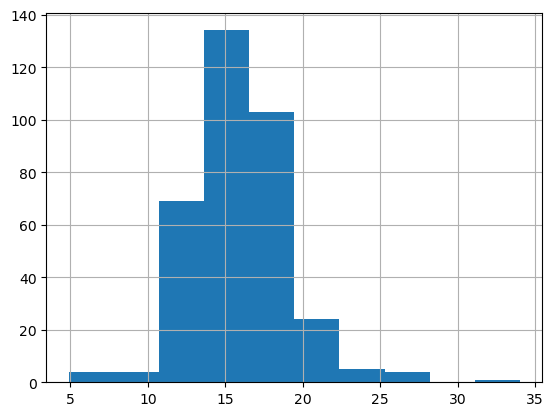

Average Salary


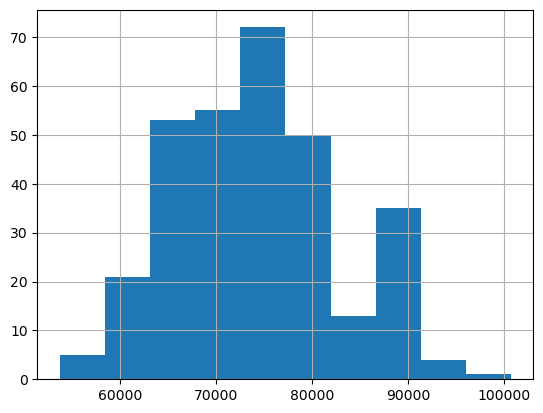

Average In-District Expenditures per Pupil


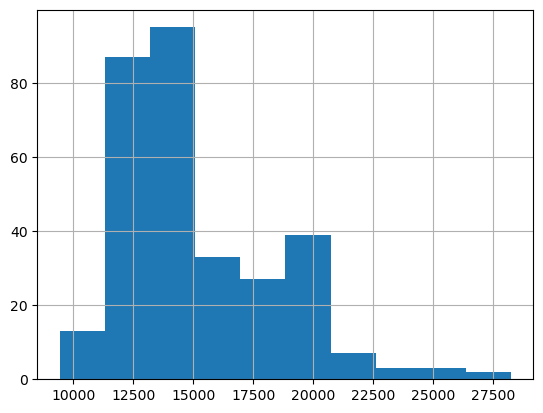

Average SAT_Reading


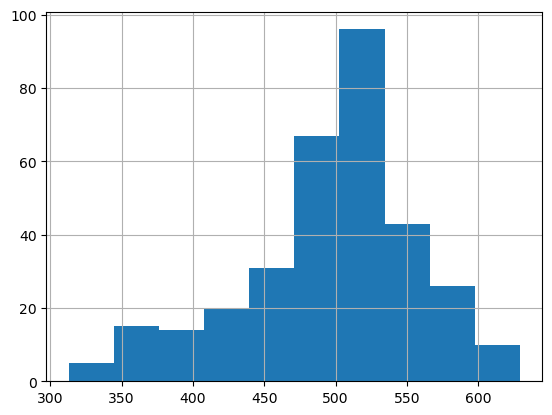

Average SAT_Writing


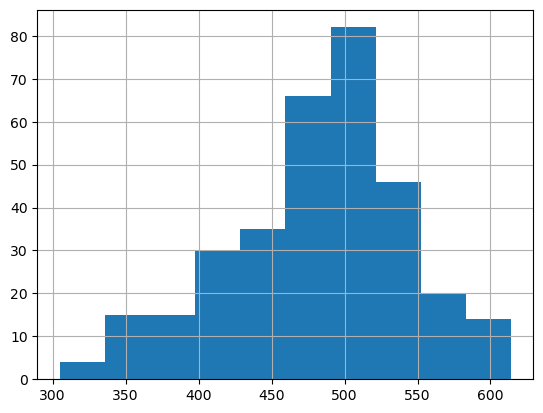

Average SAT_Math


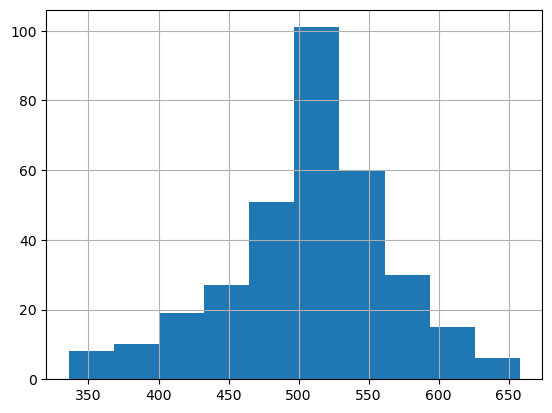

Progress and Performance Index (PPI) - All Students


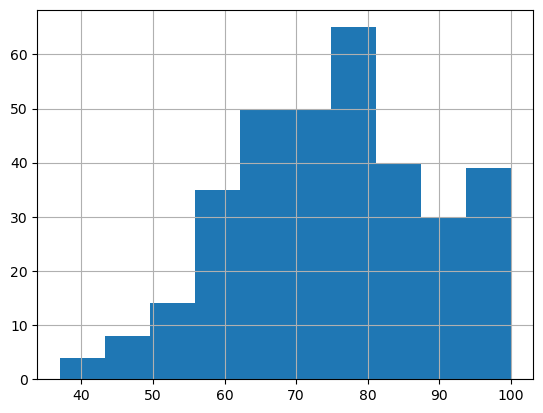

Progress and Performance Index (PPI) - High Needs Students


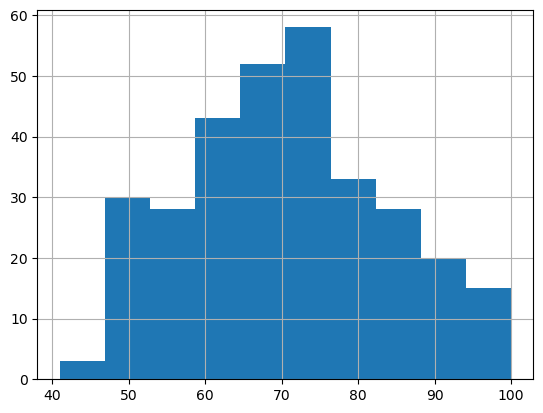

Total Pupil FTEs


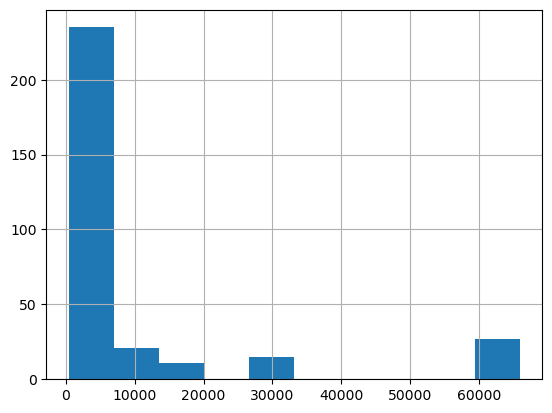

In [37]:
#histogram to represent how data is distributed for missing info
hist_fields = ['Average Class Size', 'Average Salary', 'Average In-District Expenditures per Pupil', 'Average SAT_Reading', 'Average SAT_Writing', 'Average SAT_Math', 'Progress and Performance Index (PPI) - All Students', 'Progress and Performance Index (PPI) - High Needs Students', 'Total Pupil FTEs']
for f in hist_fields:
    feature_frame_cut1[f].hist()
    print(f)
    plt.show()

Based on the results, average salary and class size are normally distributed but in district expenditures per pupil is skewed. I then wrote a function that can be used to fill missing values with either mean or median. The function takes the series to modify, the method of filling missing values as inputs, and whether the imputations are calculated at district or state level. After filling the missing values with the requested method, the function returns the updated series.

In [38]:
#Write functions for replacing missing values with mean 

#Mean fill function
def fillWithMean(frame, col_name):

    #copy the dataframe
    func_frame = frame.copy()

    #get the list of unique districts 
    dist_avgs = {}
    districts = func_frame['District Name'].unique()

    #run through each district and calculate the mean value of the requested column and add to dict, for districts without an average, use the state average value
    state_avg = func_frame[col_name].mean()
    for d in districts:
        d_avg = func_frame[func_frame['District Name'] == d][col_name].mean()
        if np.isnan(d_avg):
            dist_avgs[d] = state_avg
        else:
            dist_avgs[d] = d_avg
        
    #fill the missing values with district averages in the requested column
    func_frame[col_name] = func_frame[col_name].astype(str).replace('nan', np.nan)
    func_frame[col_name].fillna(func_frame['District Name'], inplace = True)
    func_frame[col_name] = func_frame[col_name].apply(lambda x: dist_avgs[x] if x in dist_avgs.keys() else x)

    #Convert target series into float type
    func_frame[col_name] = func_frame[col_name].astype('float')    

    #Return updated series
    return func_frame[col_name]

In [39]:
#Write functions for replacing missing values with median

#Mean fill function
def fillWithMedian(frame, col_name):

    #copy the dataframe
    func_frame = frame.copy()

    #get the list of unique districts 
    dist_meds = {}
    districts = func_frame['District Name'].unique()

    #run through each district and calculate the mean value of the requested column and add to dict, for districts without an average, use the state average value
    state_med = func_frame[col_name].median()
    for d in districts:
        d_med = func_frame[func_frame['District Name'] == d][col_name].median()
        if np.isnan(d_med):
            dist_meds[d] = state_med
        else:
            dist_meds[d] = d_med
        
    #fill the missing values with district averages in the requested column
    func_frame[col_name] = func_frame[col_name].astype(str).replace('nan', np.nan)
    func_frame[col_name].fillna(func_frame['District Name'], inplace = True)
    func_frame[col_name] = func_frame[col_name].apply(lambda x: dist_meds[x] if x in dist_meds.keys() else x)

    #Convert target series into float type
    func_frame[col_name] = func_frame[col_name].astype('float')    

    #Return updated series
    return func_frame[col_name]

In [40]:
#Impute missing demographic data 
feature_frame_cut2 = feature_frame_cut1.copy()

for i in ['Average Class Size', 'Average Salary']:
    feature_frame_cut2[i] = fillWithMean(feature_frame_cut2, i)

for i in ['Average In-District Expenditures per Pupil']:
    feature_frame_cut2[i] = fillWithMedian(feature_frame_cut2, i)

print(feature_frame_cut2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 351 entries, 0 to 1858
Data columns (total 16 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   District Name                                               351 non-null    object 
 1   School Type                                                 351 non-null    object 
 2   % First Language Not English                                351 non-null    float64
 3   % English Language Learner                                  351 non-null    float64
 4   % Students With Disabilities                                351 non-null    float64
 5   % High Needs                                                351 non-null    float64
 6   % Economically Disadvantaged                                351 non-null    float64
 7   Average Class Size                                          351 non-null    float64
 8   Aver

The next fields with missing information includes the average SAT scores for Reading, Writing, and Math. For each these columns, approximately 17% of values are missing, and normally this would be considered too much to impute. However, for this exercise, I decided to use the K Nearest Neighbors algorthim to practice using this method. The purpose of including this variable was to use it as a metric to evaluate a school's ability to prepare students for standardized tests. While prepatory courses aren't required to excel on the SATs, high SAT scores may indicate that a school encourages standardized test prep either through its curriculum or additional support such as after school classes. For this feature, I added the scores for each SAT subject to get a total SAT score and used the KNN algorithm from scikitlearn to impute missing values. SAT scores were aggregated prior to imputing missing scores to reduct the total number of imputations needed to prep this feature.

In [41]:
#Aggregate SAT scores
sat_frame = feature_frame_cut2.copy()
sat_tests = ['Average SAT_Reading', 'Average SAT_Writing', 'Average SAT_Math']
sat_frame['SAT Score'] = sat_frame['Average SAT_Reading'] + sat_frame['Average SAT_Writing'] + sat_frame['Average SAT_Math']
sat_impute_frame = sat_frame[['% First Language Not English', '% English Language Learner', '% Students With Disabilities' ,'% High Needs' ,'% Economically Disadvantaged', 'Average Class Size', 'Average Salary', 'Average In-District Expenditures per Pupil',
                              'SAT Score']]


print(sat_impute_frame.info())

#Train and apply KNN imputer
imputer = KNNImputer()
imputer.fit(sat_impute_frame)
imputed_sat_array = pd.DataFrame(imputer.transform(sat_impute_frame))
imputed_series = pd.Series(imputed_sat_array[8])
updated_frame = sat_impute_frame.copy()
updated_frame.reset_index(inplace = True)
updated_frame['imputed score'] = imputed_series
print(imputed_sat_array[8])
print(imputed_series)

print(updated_frame.info())


<class 'pandas.core.frame.DataFrame'>
Index: 351 entries, 0 to 1858
Data columns (total 9 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   % First Language Not English                351 non-null    float64
 1   % English Language Learner                  351 non-null    float64
 2   % Students With Disabilities                351 non-null    float64
 3   % High Needs                                351 non-null    float64
 4   % Economically Disadvantaged                351 non-null    float64
 5   Average Class Size                          351 non-null    float64
 6   Average Salary                              351 non-null    float64
 7   Average In-District Expenditures per Pupil  351 non-null    float64
 8   SAT Score                                   327 non-null    float64
dtypes: float64(9)
memory usage: 27.4 KB
None
0      1534.0
1      1485.0
2      1583.0
3      17

In [42]:
# Next I tried normalizing the fields to improve the performance of the KNN algorithm
scaler = MinMaxScaler()
feat_cols = sat_impute_frame[['% First Language Not English', '% English Language Learner', '% Students With Disabilities' ,'% High Needs' ,'% Economically Disadvantaged', 'Average Class Size', 'Average Salary', 'Average In-District Expenditures per Pupil']]
norm_cols = scaler.fit_transform(feat_cols)
norm_frame = pd.DataFrame(norm_cols, columns = ['% First Language Not English', '% English Language Learner', '% Students With Disabilities' ,'% High Needs' ,'% Economically Disadvantaged', 'Average Class Size', 'Average Salary', 'Average In-District Expenditures per Pupil'])

#Add the sat column to the normalized dataframe
sat_reset_frame = sat_impute_frame.reset_index()
norm_frame['SAT Score'] = sat_reset_frame['SAT Score']

#Train and apply KNN imputer
norm_imputer = KNNImputer()
norm_imputer.fit(norm_frame)
norm_imputed_sat_array = pd.DataFrame(imputer.transform(norm_frame))
norm_imputed_series = pd.Series(norm_imputed_sat_array[8])
norm_updated_frame = norm_frame.copy()
norm_updated_frame.reset_index(inplace = True)
norm_updated_frame['imputed score'] = norm_imputed_series

print(norm_updated_frame.info())

norm_imputed_frame = norm_updated_frame.drop(['SAT Score', 'index'], axis = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 11 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   index                                       351 non-null    int64  
 1   % First Language Not English                351 non-null    float64
 2   % English Language Learner                  351 non-null    float64
 3   % Students With Disabilities                351 non-null    float64
 4   % High Needs                                351 non-null    float64
 5   % Economically Disadvantaged                351 non-null    float64
 6   Average Class Size                          351 non-null    float64
 7   Average Salary                              351 non-null    float64
 8   Average In-District Expenditures per Pupil  351 non-null    float64
 9   SAT Score                                   327 non-null    float64
 10  imputed score 

In [43]:
#With the imputed SAT scores, the only step left is to normalized the imputed score column
cols = norm_imputed_frame.columns
feature_frame = pd.DataFrame(scaler.fit_transform(norm_imputed_frame), columns = cols)
print(feature_frame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 9 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   % First Language Not English                351 non-null    float64
 1   % English Language Learner                  351 non-null    float64
 2   % Students With Disabilities                351 non-null    float64
 3   % High Needs                                351 non-null    float64
 4   % Economically Disadvantaged                351 non-null    float64
 5   Average Class Size                          351 non-null    float64
 6   Average Salary                              351 non-null    float64
 7   Average In-District Expenditures per Pupil  351 non-null    float64
 8   imputed score                               351 non-null    float64
dtypes: float64(9)
memory usage: 24.8 KB
None
